# Inference LoRA und Stable Diffusion XL

Von Ramon Wartala für die [iX]()


## Prüfen ob das Notebook mit GPU-Beschleunigung läuft

In den Einstellungen von Google Colab sollte die T4 GPU-Beschleunigung ausgewählt sein. Ob dies der Fall ist lässt sich mit diesem einfachen Befehl prüfen. Im Erfolgsfall wird die Zeile GPU 0: Tesla T4 (UUID: XXXXX) augegeben, wobei XXXdurch eine eindeutige ID ersetzt wird.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3fe49864-d4f7-9814-402e-5f8d6dbf7b54)


## Die nötigen Bibliotheken installieren

In [2]:
!pip install xformers bitsandbytes transformers accelerate datasets Pillow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00


In [3]:
!pip install -q git+https://github.com/huggingface/diffusers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Einfache Inferenz mit SDXL 1.0

In [1]:
from diffusers import DiffusionPipeline
import torch

from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae, torch_dtype=torch.float16, variant="fp16",
    use_safetensors=True
)

_ = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 50
seed = 3
cross_attention_scale = 0.7

In [3]:
prompt = "photo of he-man in dark dense foggy forest"
negative_prompt = "blurry, distorted face, poorly drawn hands, poorly drawn fingers, poorly drawn face, poorly drawn nose, poorly drawn legs, poorly drawn arms"

In [4]:
image = pipe(
  prompt=prompt,
  negative_prompt=negative_prompt,
  num_inference_steps=n_steps,
  generator=torch.Generator(device='cuda').manual_seed(seed),
  cross_attention_kwargs={"scale": cross_attention_scale},
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

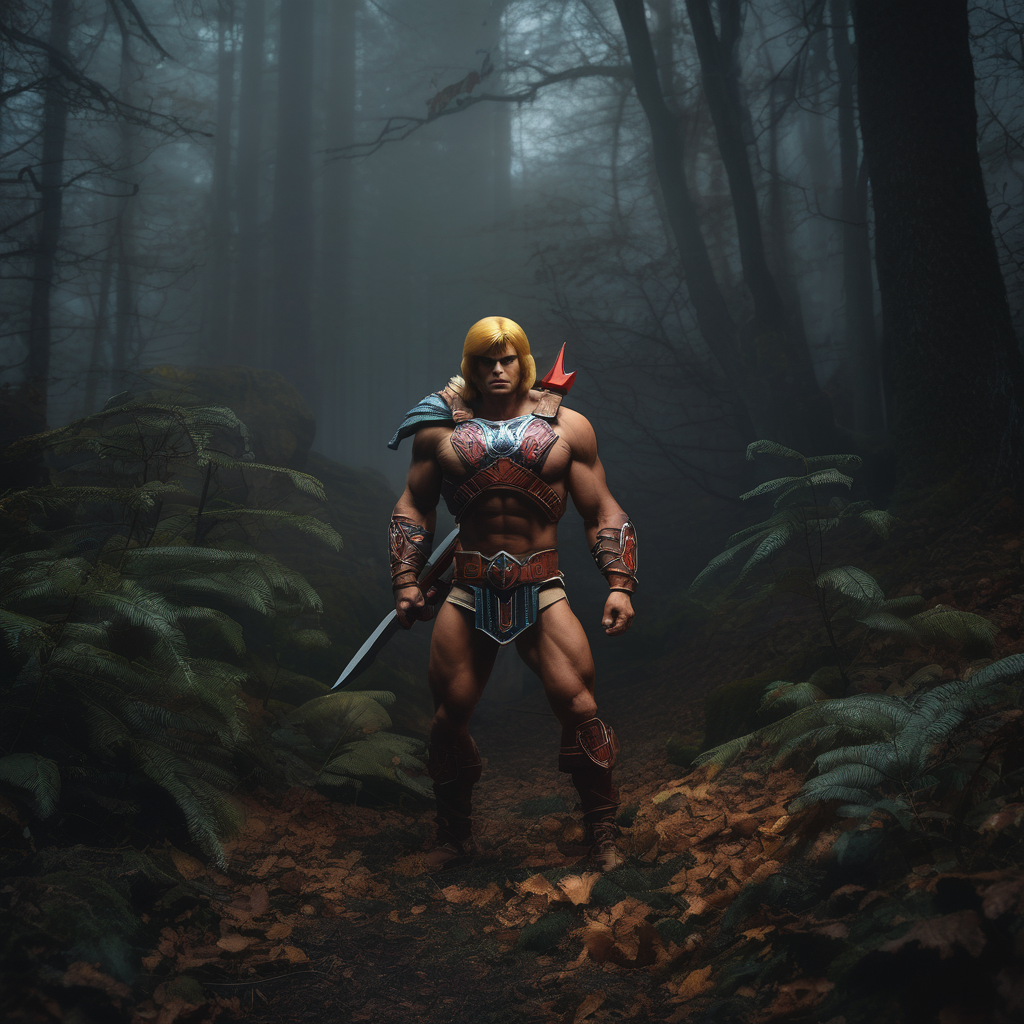

In [5]:
image

In [6]:
image.save("heman-dark-forrest-without-lora.png")

## Einfache Inferenz mit SDXL 1.0 und LoRA

In [25]:
from diffusers import DiffusionPipeline
import torch

from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae, torch_dtype=torch.float16, variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights("Rawar/heman-toy-lora-trained-sdxl")

_ = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [39]:
# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 50
seed = 3
cross_attention_scale = 0.7

In [40]:
prompt = "photo of he-man in dark dense foggy forest"
negative_prompt = "blurry, distorted face, poorly drawn hands, poorly drawn fingers, poorly drawn face, poorly drawn nose, poorly drawn legs, poorly drawn arms"

In [41]:
image = pipe(
  prompt=prompt,
  negative_prompt=negative_prompt,
  num_inference_steps=n_steps,
  generator=torch.Generator(device='cuda').manual_seed(seed),
  cross_attention_kwargs={"scale": cross_attention_scale},
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

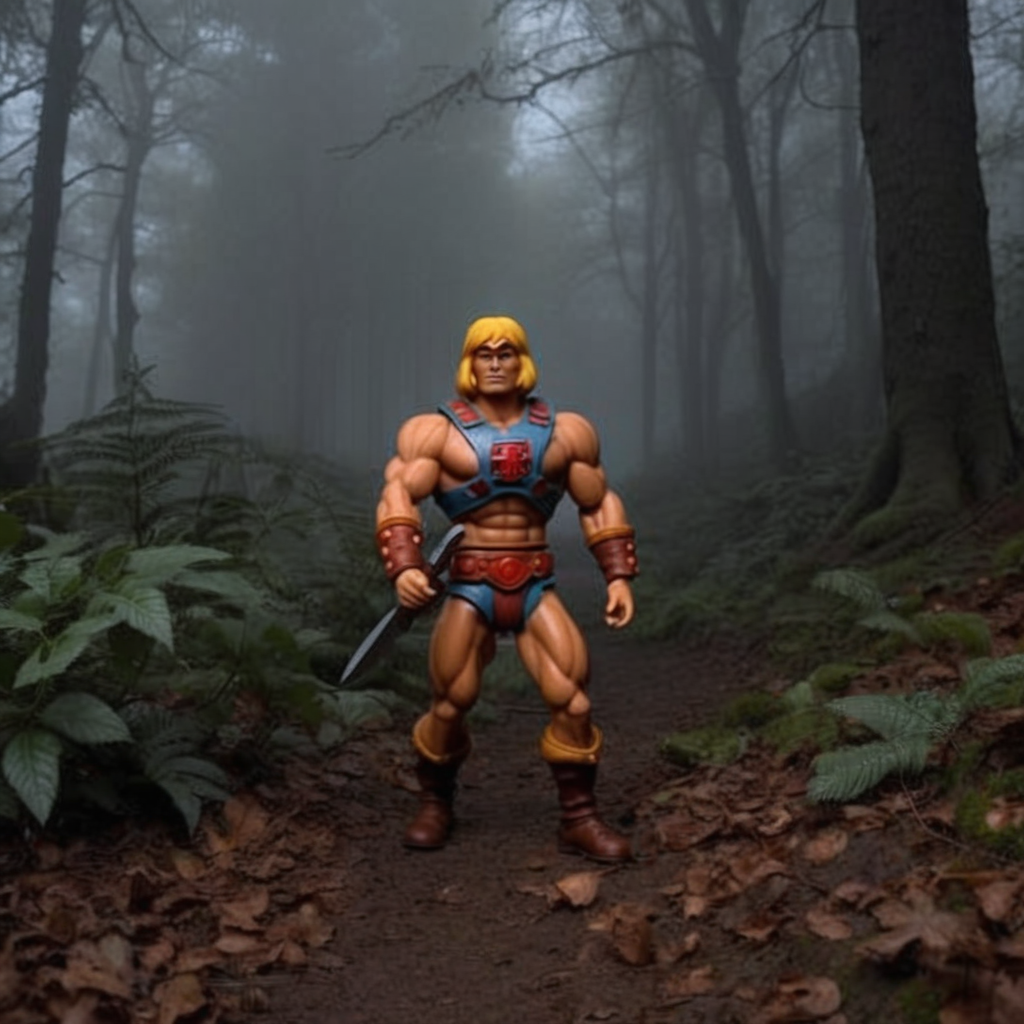

In [42]:
image

In [43]:
image.save("heman-dark-forrest2.png")

## Inferenz mit Refiner

In [1]:
from diffusers import DiffusionPipeline
import torch

from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)

base.load_lora_weights("Rawar/heman-toy-lora-trained-sdxl")
base.enable_model_cpu_offload()

refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)

refiner.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [2]:
# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 50
high_noise_frac = 0.7
seed = 3
cross_attention_scale = 0.7

In [3]:
prompt = "photo of he-man in dark dense foggy forest"
negative_prompt = "blurry, distorted face, poorly drawn hands, poorly drawn fingers, poorly drawn face, poorly drawn nose, poorly drawn legs, poorly drawn arms"

In [4]:
image = base(
  prompt=prompt,
  negative_prompt=negative_prompt,
  num_inference_steps=n_steps,
  denoising_end=high_noise_frac,
  generator=torch.Generator(device='cuda').manual_seed(seed),
  cross_attention_kwargs={"scale": cross_attention_scale},
  output_type="latent",
).images


  0%|          | 0/35 [00:00<?, ?it/s]

In [5]:
image = refiner(
    prompt=prompt,
    negative_prompt=negative_prompt,
    generator=torch.Generator(device='cuda').manual_seed(seed),
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

  0%|          | 0/15 [00:00<?, ?it/s]

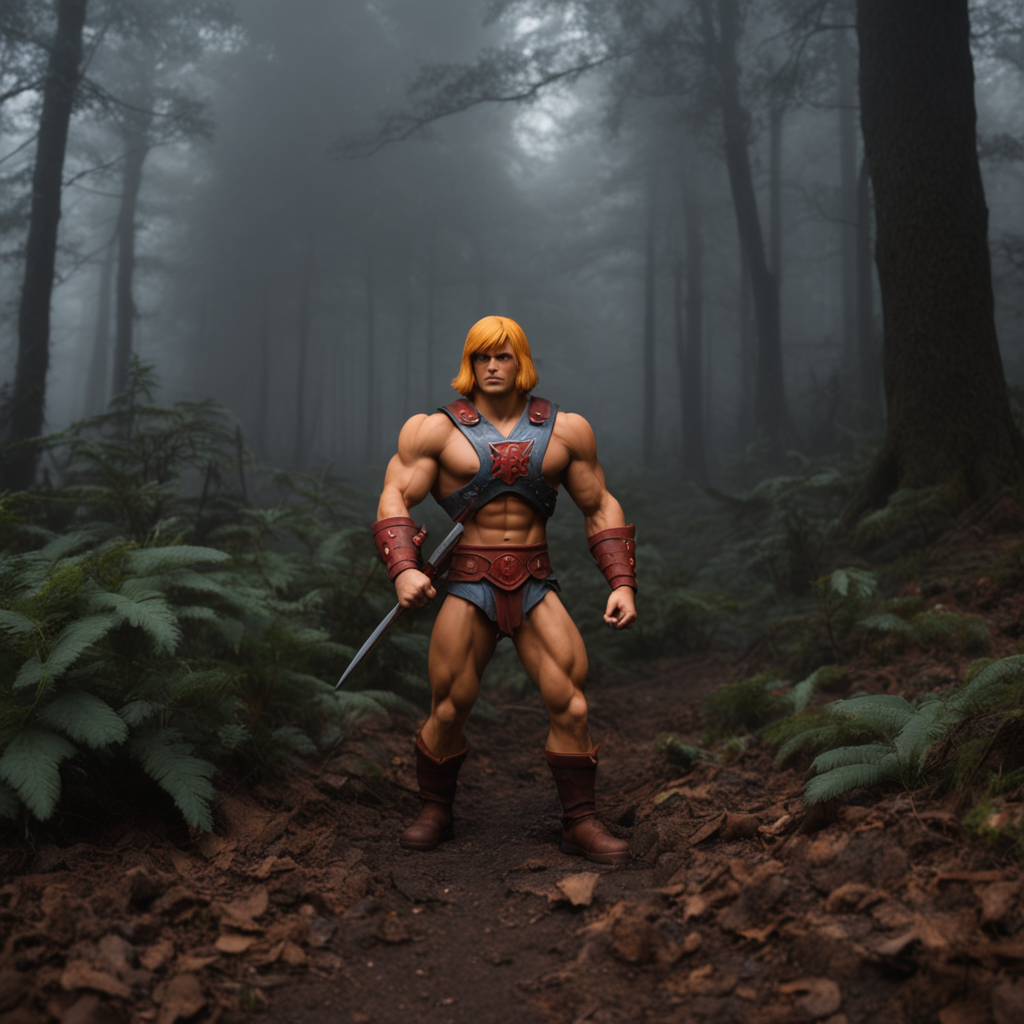

In [6]:
image

In [7]:
image.save("heman-dark-forrest-refiner2.png")